# RNN 이해 및 실습

## 1. 시계열 데이터

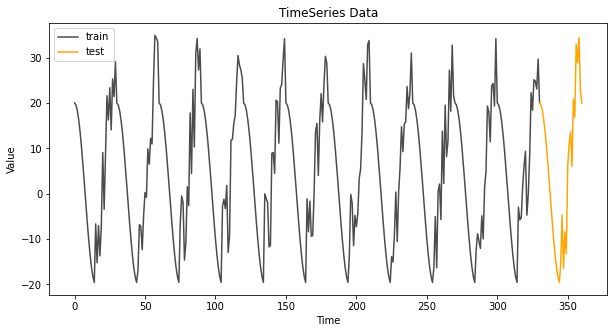

In [1]:
import numpy as np
import matplotlib.pyplot as plt

xarr = np.array([100,200,300,400])
yarr = np.array([1,2,3,4])
cond = ([True,False,True,False])
np.where(cond,xarr,yarr) #cond True->xarr, False ->yarr

np.random.seed(2020)

time = np.arange(30 * 12 + 1)
month_time = (time % 30) / 30
time_series = 20 * np.where(month_time < 0.5, 
                          np.cos(2 * np.pi * month_time),
                          np.cos(2 * np.pi * month_time) + np.random.random(361))

plt.figure(figsize = (10, 5))
plt.title('TimeSeries Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(np.arange(0, 30 * 11 + 1), time_series[:30 * 11 + 1], color = 'black', alpha = 0.7, label = 'train') # 학습용 데이터
plt.plot(np.arange(30 * 11, 30 * 12 + 1), time_series[30 * 11:], color = 'orange', label = 'test') # 테스트용 데이터
plt.legend()

## 2. 시계열 데이터 전처리 : Sequence를 만들기

In [2]:
def make_sequence(time_series, n):
    x_train, y_train = list(), list()
    
    for i in range(len(time_series)):
        x = time_series[i:(i + n)]
        if (i + n) < len(time_series):
            x_train.append(x)
            y_train.append(time_series[i + n])
        else:
            break
            
    return np.array(x_train), np.array(y_train)

n = 10
x_train, y_train = make_sequence(time_series, n)

x_train = x_train.reshape(-1, n, 1)
y_train = y_train.reshape(-1, 1)

from sklearn.model_selection import train_test_split

patial_x_train = x_train[:30 * 11]
patial_y_train = y_train[:30 * 11]
x_test = x_train[30 * 11:]
y_test = y_train[30 * 11:]

print('train:', patial_x_train.shape, patial_y_train.shape) 
print('test:',x_test.shape, y_test.shape)

train: (330, 10, 1) (330, 1)
test: (21, 10, 1) (21, 1)


## 3. 데이터 형태 확인하기

In [3]:
test_arr = np.arange(100)
a, b = make_sequence(test_arr, 10)

for i in range(1, 4):
    print(a[i],'|', b[i])


[ 1  2  3  4  5  6  7  8  9 10] | 11
[ 2  3  4  5  6  7  8  9 10 11] | 12
[ 3  4  5  6  7  8  9 10 11 12] | 13


## 4. SimpleRNN 구축

In [4]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
# SimpleRNN 층을 첫 번째 은닉층인 경우,
# input_shape를 명시해주어야 합니다.
model.add(SimpleRNN(units = 32, activation = 'tanh', input_shape = (n, 1))) #units: output의 dimension
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

2022-04-04 14:43:21.809013: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-04 14:43:21.809121: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.fit(x_train, y_train, epochs = 5, batch_size = 1)

Epoch 1/5


2022-04-04 14:43:22.595089: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-04 14:43:22.916353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


351/351 [==============================] - 16s 38ms/step - loss: 153.2266
Epoch 2/5
351/351 [==============================] - 13s 38ms/step - loss: 84.3131
Epoch 3/5
351/351 [==============================] - 13s 37ms/step - loss: 64.6289
Epoch 4/5
351/351 [==============================] - 13s 37ms/step - loss: 55.1886
Epoch 5/5
351/351 [==============================] - 13s 38ms/step - loss: 50.1504


## 5. 예측 VS Actual
- Epoch를 늘린다면?

2022-04-04 14:44:31.411376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


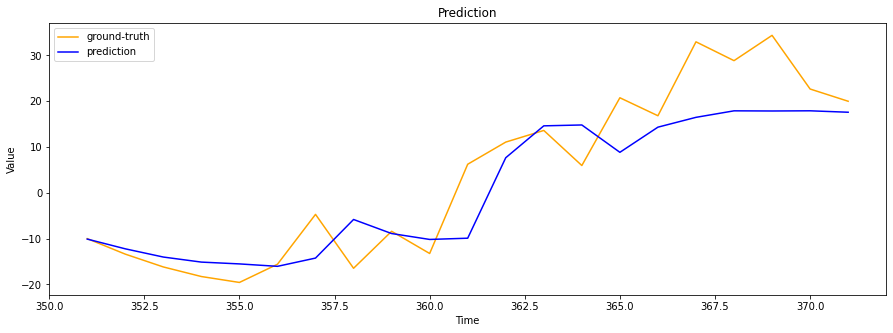

In [6]:
pred = model.predict(x_test)
pred_range = np.arange(len(y_train), len(y_train) + len(pred))

plt.figure(figsize=(15,5))
plt.title('Prediction')
plt.xlabel('Time'); plt.ylabel('Value')
plt.plot(pred_range, y_test.reshape(-1,), color='orange', label='ground-truth')
plt.plot(pred_range, pred.reshape(-1,), color='blue', label='prediction')
plt.legend()
plt.show()

## 6. 두번째 RNN 실습
- 어떤 RNN을 구성하는지? 1:m, m:1 ...
- m:1은 이전 n개의 값으로 이후 1개의 값을 예측


In [7]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import gridspec

s = np.sin(2 * np.pi * 0.125 * np.linspace(0, 20, 50))
timestep =3 # t-3, t-2, t-1 데이터를 이용하여 t 시점의 값을 예측 
xs, ys = [], []

for i in range(timestep, len(s)):
    xs.append(np.array([s[i-j] for j in range(timestep, 0, -1)]))
    ys.append(s[i])
xs, ys = np.array(xs).reshape(len(xs), 3, 1), np.array(ys).reshape(len(ys), 1)



- RNN 입력 x 데이터의 shape: (n_sample, time step, x vector의 크기) 
 - n_sample: sample의 수 
 - time step: t-n 에서 n이 몇인가를 묻는 것
 - x vector의 크기: 현재는 1개, 추후 여러 값이 입력, 여러값이 출력될 수 있음.
 - xvector의 크기 = yvector의 크기와 동일

2022-04-04 14:44:32.300983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


---model_0: training complete---


2022-04-04 14:44:36.416756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


---model_1: training complete---


2022-04-04 14:44:40.445264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-04 14:44:40.542833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


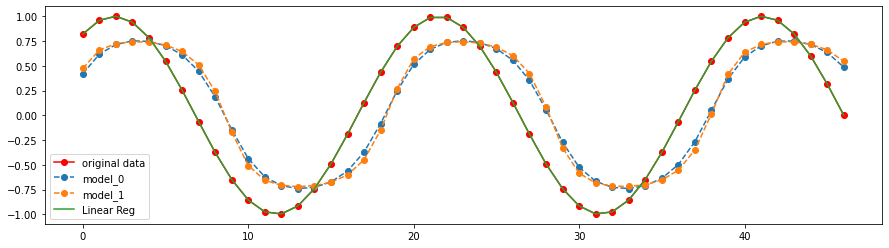

In [8]:
## rnn 적용. 
from sklearn.linear_model import LinearRegression #benchmark용
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

## benchmark model: Linear Regression
reg  = LinearRegression()
reg.fit(xs.reshape(len(xs), 3), ys)

## simple RNN model 
np.random.seed(0)# seed 고정
models = [ 
    Sequential([SimpleRNN(units=1, input_shape=(3, 1)),
    ]), 
    Sequential([SimpleRNN(units=1, input_shape=(3, 1)),
                Dense(10, activation='linear'), 
                Dense(1, activation='linear'), 
    ]),
]

for i, m in enumerate(models):
    m.compile(loss='mse', optimizer='sgd')
    history = m.fit(xs, ys, epochs=150, verbose=0)
    print("---model_{}: training complete---".format(i))

## plot 
fig = plt.figure(figsize=(15, 4)) 
plt.plot(s[3:], 'ro-', label='original data') # 원래 plot, 앞의 3칸의 경우, 
for i, m in enumerate(models):
    plt.plot(m.predict(xs), '--', marker='o', label='model_{}'.format(i))
plt.plot(reg.predict(xs.reshape(len(xs), 3)), label='Linear Reg')
plt.legend()

plt.savefig('simple_rnn.svg')
plt.show()

## 8. RNN 적용을 위한 텍스트 처리
- one hot encoding

In [9]:
#단어 수준의 원-핫 인코딩 
import numpy as np

# 초기 데이터: 각 sample이 각 문장
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# tokenization
token_index = {}
for sample in samples:
    # split() 메서드를 사용해 샘플을 토큰으로 나눕니다.
    for word in sample.split():
        if word not in token_index:
            # 토큰마다 인덱스 부여
            token_index[word] = len(token_index) + 1
            # 인덱스는 1부터 부여

# 샘플을 벡터로 변환: 각 샘플에서 max_length 까지의 단어만 사용 -> 크기 고정
max_length = 10

# 결과 저장
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

In [10]:
#문자 수준 원-핫 인코딩
import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable  # 출력 가능한 모든 아스키(ASCII) 문자
token_index = dict(zip(characters, range(1, len(characters) + 1)))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample[:max_length]):
        index = token_index.get(character)
        results[i, j, index] = 1.

In [11]:
#케라스를 사용한 단어 수준의 원-핫 인코딩
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# 가장 빈도가 높은 1,000개의 단어만 선택하도록 Tokenizer 객체
tokenizer = Tokenizer(num_words=1000)
# 단어 인덱스를 구축
tokenizer.fit_on_texts(samples)

# 문자열을 정수 인덱스의 리스트로 변환
sequences = tokenizer.texts_to_sequences(samples)

# 원-핫 binary 벡터 표현
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

# 계산된 단어 인덱스
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9 unique tokens.


- One Hot Hashing
 - dictionary에 있는 토큰의 수가 많은 경우 사용
 - 각 토큰에 인덱스 부여하고 dictionary에 저장하는 대신 토큰을 hashing하여 고정된 크기의 벡터화
 -  해시 충돌(=서로 다른 두 개의 입력값에 대해 동일한 출력값을 내는 상황)에 대한 주의

In [12]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# 단어를 크기가 1,000인 벡터로 저장합니다.
# 1,000개(또는 그이상)의 단어가 있다면 해싱 충돌이 늘어나고 인코딩의 정확도가 감소될 것입니다
dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        # 단어를 해싱하여 0과 1,000 사이의 랜덤한 정수 인덱스로 변환합니다.
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

- One hot encoding VS Embedding
 - One hot encoding: sparse, high dimensional, hard-coded
 - Embedding: dense, low dimensional, learned from data 

- Embedding !
 - 단어의 임베딩: 단어를 "좌표"로 변환
 - 모든 상황에 적합한 단어 임베딩 공간? 각 데이터셋에 각각의 임베딩
 - Embedding 층을 통한 학습

In [13]:
from tensorflow.keras.layers import Embedding

# Embedding 층은 적어도 두 개의 매개변수를 받습니다.
# 가능한 토큰의 개수(여기서는 1,000으로 단어 인덱스 최댓값 + 1입니다)와 임베딩 차원(여기서는 64)입니다
embedding_layer = Embedding(1000, 64)

- Embedding 층: (samples, sequence_length, embedding_dimensionality)의 shape를 갖는 3D 실수형 텐서 반환, RNN이나 1D CNN에서 처리

- Embedding 층: 가중치 무작위 초기화, 역전파로 조정, 학습 후 데이터에 특화된 임베딩 



## 9. text에 RNN 적용 예제: IMDB 영화 리뷰 감성 예측 
- 총 50000개 리뷰로 긍부정 분류(train 25000개)
- 영화 리뷰 중 고빈도 10000개 단어, 리뷰는 20개 이후 단어는 제외
- 10000개 단어를 8차원 임베딩 학습
- 정수 시퀀스 입력(2D 정수 텐서)을 임베딩 시퀀스(3D 실수형 텐서)로 변환
- 이후 텐서를 2D화 하여 Dense층 연결


1) Tokenization + 일반 DNN

In [2]:
#영화 리뷰 분류
#0. 사용할 패키지 불러오기
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)



[1 0 0 ... 0 1 0]
-------
[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 194, 8

In [15]:
import numpy as np

def vectorize_sequence(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    #크기가 (len(sequences), dimension)이고 모든 원소가 0인 행렬 만들기
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
        #result[i] 에서 특정 인덱스의 위치를 1로 만듦
    return results
x_train =vectorize_sequence(train_data)
x_test = vectorize_sequence(test_data)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [16]:
x_train

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [17]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [18]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                160016    
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160,161
Trainable params: 160,161
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['acc'])

In [20]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [21]:
history = model.fit(partial_x_train, partial_y_train, epochs= 10, batch_size = 512, validation_data = (x_val, y_val))

Epoch 1/10


2022-04-04 14:44:48.066058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 40ms/step - loss: 0.6011 - acc: 0.6808 - val_loss: 0.4940 - val_acc: 0.8206
Epoch 2/10
 1/30 [>.............................] - ETA: 0s - loss: 0.4544 - acc: 0.8750

2022-04-04 14:44:50.187920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 15ms/step - loss: 0.3895 - acc: 0.8896 - val_loss: 0.3543 - val_acc: 0.8801
Epoch 3/10
30/30 [==============================] - 0s 13ms/step - loss: 0.2575 - acc: 0.9297 - val_loss: 0.2953 - val_acc: 0.8926
Epoch 4/10
30/30 [==============================] - 0s 13ms/step - loss: 0.1854 - acc: 0.9487 - val_loss: 0.2814 - val_acc: 0.8886
Epoch 5/10
30/30 [==============================] - 0s 12ms/step - loss: 0.1405 - acc: 0.9639 - val_loss: 0.2896 - val_acc: 0.8842
Epoch 6/10
30/30 [==============================] - 0s 14ms/step - loss: 0.1089 - acc: 0.9743 - val_loss: 0.3044 - val_acc: 0.8817
Epoch 7/10
30/30 [==============================] - 0s 12ms/step - loss: 0.0848 - acc: 0.9830 - val_loss: 0.3185 - val_acc: 0.8801
Epoch 8/10
30/30 [==============================] - 0s 12ms/step - loss: 0.0660 - acc: 0.9893 - val_loss: 0.3467 - val_acc: 0.8762
Epoch 9/10
30/30 [==============================] - 0s 12ms/step - loss: 0.0523 - acc: 0.9924 

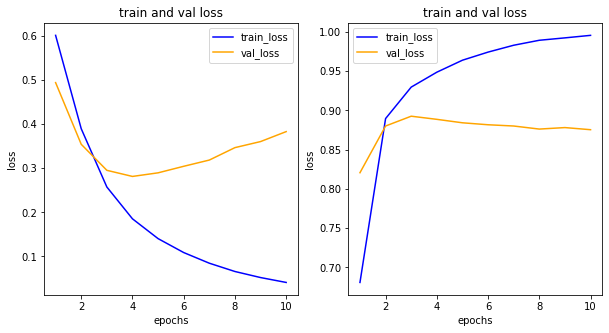

In [22]:
#학습결과 그려보기
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] # 검증 데이터가 있는 경우 val_ 수식어가 붙는다.

epochs = range(1,len(loss)+1 )
fig = plt.figure(figsize= (10,5) )

# 학습 및 검증 손실 그리기

ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 학습 및 검증 정확도 그리기
ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_loss')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_loss')
ax2.set_title('train and val loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.legend()


plt.show()

In [23]:
model.evaluate(x_test,y_test)

782/782 [==============================] - 3s 4ms/step - loss: 0.4197 - acc: 0.8633


[0.4197067320346832, 0.8633200526237488]

2) Simple RNN

In [24]:
from tensorflow.keras.datasets import imdb

num_words = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)

from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 500

pad_X_train = pad_sequences(X_train, maxlen=max_len)  #각 리뷰를 같은 길이로 고정
pad_X_test = pad_sequences(X_test, maxlen=max_len)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding  

model = Sequential()
model.add(Embedding(input_dim = num_words, output_dim = 32)) 
# return_sequences, dropout, recurrent_dropout
model.add(SimpleRNN(32, return_sequences = True, dropout = 0.15, recurrent_dropout = 0.15))
model.add(SimpleRNN(32))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics = ['acc'])

model.summary()
#5분 이상 소요!
history = model.fit(pad_X_train, y_train, 
                    batch_size = 32, epochs = 1,  #epoch를 늘려보기!
                    validation_split = 0.2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 324,193
Trainable params: 324,193
Non-trainable params: 0
_________________________________________________________________


2022-04-04 14:45:01.717781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


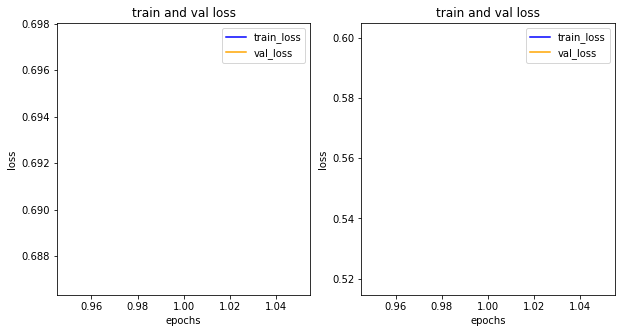

In [ ]:
#학습결과 그려보기
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] # 검증 데이터가 있는 경우 val_ 수식어가 붙는다.

epochs = range(1,len(loss)+1 )
fig = plt.figure(figsize= (10,5) )

# 학습 및 검증 손실 그리기

ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 학습 및 검증 정확도 그리기
ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_loss')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_loss')
ax2.set_title('train and val loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.legend()


plt.show()

3) "imdb + One hot encoding + 일반 DNN"과의 비교 

In [ ]:
# Loading the data (it's preloaded in Keras)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=1000)

print(x_train.shape)
print(x_test.shape)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


(25000,)
(25000,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


- one-hot encoding



In [ ]:
# One-hot encoding the output into vector mode, each of length 1000
tokenizer = Tokenizer(num_words=1000)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print(x_train[0])

[0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

In [ ]:
# One-hot encoding the output
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_train.shape)
print(y_test.shape)

(25000, 2)
(25000, 2)


In [ ]:
from keras import optimizers
from keras.layers import Dense,Dropout
model = Sequential()
model.add(Dense(300, activation="relu",input_dim=(1000)))
model.add(Dropout(0.5))

model.add(Dense(2,activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
hist = model.fit(x_train, y_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_test, y_test), 
          verbose=1)

Epoch 1/10
782/782 [==============================] - 4s 5ms/step - loss: 0.3876 - accuracy: 0.8270 - val_loss: 0.3260 - val_accuracy: 0.8604
Epoch 2/10
782/782 [==============================] - 4s 5ms/step - loss: 0.3108 - accuracy: 0.8666 - val_loss: 0.3211 - val_accuracy: 0.8607
Epoch 3/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2763 - accuracy: 0.8849 - val_loss: 0.3226 - val_accuracy: 0.8598
Epoch 4/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2339 - accuracy: 0.9061 - val_loss: 0.3300 - val_accuracy: 0.8596
Epoch 5/10
782/782 [==============================] - 3s 4ms/step - loss: 0.1874 - accuracy: 0.9273 - val_loss: 0.3394 - val_accuracy: 0.8600
Epoch 6/10
782/782 [==============================] - 3s 4ms/step - loss: 0.1387 - accuracy: 0.9490 - val_loss: 0.3688 - val_accuracy: 0.8582
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 0.1016 - accuracy: 0.9640 - val_loss: 0.4081 - val_accuracy: 0.8543
Epoch 

- Evlaution


In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: ", score[1])

Accuracy:  0.8550800085067749


4) "imdb+embedding+DNN"과의 비교

In [ ]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

- EDA
 - data: 전처리된 정수 배열
 - label:  0 또는 1 (0: neg, 1:pos)

In [ ]:
print("train: {}, label: {}".format(len(train_data), len(train_labels)))

train: 25000, label: 25000


- review text: 단어를 의미하는 정수로 변환됨

In [ ]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


- 각 리뷰들의 길이를 같게 맞춤

In [ ]:
len(train_data[0]), len(train_data[1])

(218, 189)

- 정수를 단어로 다시 변환: dictionary내 맵핑된 단어 출력

In [ ]:
# 단어와 정수 인덱스를 매핑한 딕셔너리
word_index = imdb.get_word_index()

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

- decode_review함수로 단어로 표현된 리뷰 확인

In [ ]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

- 데이터 준비
 - 리뷰-정수 배열-가 텐서로 변환
 - 원-핫 인코딩(one-hot encoding): 많은 메모리 사용 `num_words * num_reviews` 크기의 행렬이 필요
 - 또는 정수 배열의 길이가 모두 같도록 패딩(padding)을 추가해 `max_length * num_reviews` 크기의 정수 텐서로 일치, 이후 임베딩(embedding) 층을 신경망의 첫 번째 층으로 사용
 -두 번째 방법을 활용하며, pad_sequences로 리뷰의 길이를 맞춤

In [ ]:
import tensorflow.keras as keras

train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

NameError: ignored

In [ ]:
len(train_data[0]), len(train_data[1])  #크기가 맞춰짐

(256, 256)

In [ ]:
print(train_data[0])  #padding된 첫번째 리뷰 출력

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

- modeling


In [ ]:
# 입력 크기는 영화 리뷰 데이터셋에 적용된 어휘 사전의 크기입니다(10,000개의 단어)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16, input_shape=(None,)))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_12 (Dense)            (None, 16)                272       
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


- 첫번째 은닉층: embedding층, 인코딩된 단어를 임베딩 벡터로 변환, 변환된 shape는  `(batch, sequence, embedding)`
 - `GlobalAveragePooling1D` 층은 `sequence` 차원에 대해 평균을 계산하여 각 샘플에 대해 고정된 길이의 출력 벡터를 반환, 길이가 다른 입력을 다루는  방법
 - Global Average Pooling: Max(Average) Pooling 보다 더 많이 feature의 수 축소
 - GAP의 목적은 feature를 1차원 벡터로 변환
 - 고정 길이의 출력 벡터는 16개의 은닉 유닛을 가진 완전 연결(fully-connected) 층(`Dense`)
 - 마지막 층은 하나의 출력 노드(node)를 가진 완전 연결(FC) 층:  `sigmoid` 활성화 함수를 사용하여 0과 1 사이의 실수를 출력

 - <img src = 'https://gaussian37.github.io/assets/img/dl/concept/gap/5.png'>

 - 같은 채널 (같은 색)의 feature들을 average pooling한 후 채널의 갯수(색의 갯수) 만큼 원소를 갖는 벡터화
 - (height, width, channel) 형태의 feature를 (channel,) 형태로 1차원으로 변환
- GAP은 원래 CNN + FC(Fully Connected) Layer 구성에서 FC Layer 안쓰기 위한 대안으로 도입
 - FC layer를 사용하면 하이퍼파라미터 수가 증가하고 conv-pool로 유지되는 위치정보 사라짐, conv-pool 출력을 FC layer에 들어가는 입력 사이즈로의 사이즈로 맞춰줘야 하는 단덤
- GAP는 어떤 크기의 feature 라도 같은 채널의 값들을 하나의 평균 값으로 대체하기 때문에 벡터가 만들어짐
 - 어떤 사이즈의 입력도 가능
 - (H, W, C) → (1, 1, C) 크기로 줄어드는 연산, 하이퍼파라미터 추가되지 않음
 - 하이퍼파라미터 급증으로 인한 오버피팅에도 유리
 
- FC 층 대신 GAP로 1차원 벡터화 가능 / FC와 같이 사용되기도 함

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

- validation set: train 데이터에서 10,000개의 샘플을 떼어내어 *validation 세트*(validation set)를 만들어 모형 튜닝

In [ ]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 1s 18ms/step - loss: 0.6916 - accuracy: 0.5067 - val_loss: 0.6897 - val_accuracy: 0.5387
Epoch 2/40
30/30 [==============================] - 0s 15ms/step - loss: 0.6856 - accuracy: 0.5849 - val_loss: 0.6819 - val_accuracy: 0.6101
Epoch 3/40
30/30 [==============================] - 0s 14ms/step - loss: 0.6732 - accuracy: 0.6715 - val_loss: 0.6666 - val_accuracy: 0.6993
Epoch 4/40
30/30 [==============================] - 0s 14ms/step - loss: 0.6516 - accuracy: 0.7314 - val_loss: 0.6424 - val_accuracy: 0.7353
Epoch 5/40
30/30 [==============================] - 0s 14ms/step - loss: 0.6201 - accuracy: 0.7732 - val_loss: 0.6097 - val_accuracy: 0.7696
Epoch 6/40
30/30 [==============================] - 0s 15ms/step - loss: 0.5798 - accuracy: 0.8067 - val_loss: 0.5692 - val_accuracy: 0.8044
Epoch 7/40
30/30 [==============================] - 0s 14ms/step - loss: 0.5335 - accuracy: 0.8317 - val_loss: 0.5261 - val_accuracy: 0.8232
Epoch 8/40
30

In [ ]:
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results)

782/782 - 1s - loss: 0.3361 - accuracy: 0.8722
[0.3361080586910248, 0.8722400069236755]


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

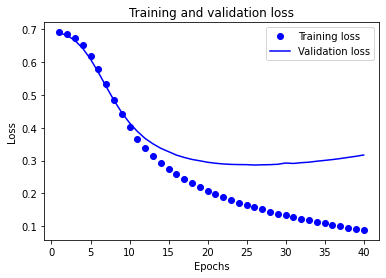

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

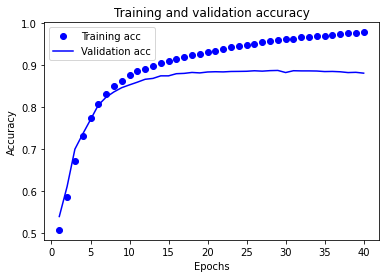

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 10. RNN 활용 기온 예측 예제
- 10분 간격 기록된 (기온, 기압, 습도, 풍향 등과 같은) 14개의 관측값
- 원본 데이터는 2003년부터, 예제에서 2009~2016년 사이의 데이터만 사용
- 최근 데이터(몇 일치 데이터 포인트)를 입력, 1일 후 기온 예측

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip /content/jena_climate_2009_2016.csv.zip

--2022-03-13 07:37:05--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.94.189
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.94.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  14.0MB/s    in 0.9s    

2022-03-13 07:37:06 (14.0 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  /content/jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
import os
f = open('jena_climate_2009_2016.csv')
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


- 420,551개 데이터를 numpy array 변환

In [ ]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

- 시간별 기온(섭씨) 그래프

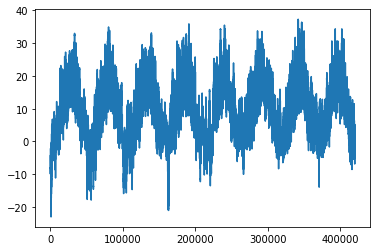

In [ ]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # 온도(섭씨)
plt.plot(range(len(temp)), temp)
plt.show()

- 기온의 주기성
- 첫 10일간의 기온 데이터, 10분 간격으로 하루에 144개 관측치
- 일별 주기성, 일일 기온 변화가 크고, 시계열 데이터로 예측

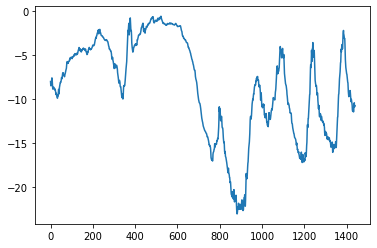

In [ ]:
plt.plot(range(1440), temp[:1440])
plt.show()

### 데이터 준비 및 전처리
- lookback 타임스텝(하나의 타임스텝은 10분) 지정, 이 만큼 이전으로 가서 샘플링, 24시간 delay후 기온 예측

 - lookback = 1440 : 10일 전 데이터로 돌아갑니다.
 - steps = 6 : 한 시간마다 데이터 포인트 하나를 샘플링합니다.
 - delay = 144 : 24시간이 지난 데이터가 타깃이 됩니다.

- 데이터 전처리: 값의 스케일링
- float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출
 - 모든 샘플을 각기 메모리에 올리는 것은 비효율적이어서, 필요 시 원본 데이터에서 배치를 생성
 - 각 값은 standard scaling
 - 전체 데이터 중 20만개 observation을 train으로 사용, 표준화 시 해당 범위 내 data로 평균 및 편차 계산

In [ ]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

- Sequence 제너레이터:(samples, targets) 튜플을 반복적으로 반환. samples는 입력 데이터로 사용할 배치이고 targets은 이에 대응되는 타깃 온도의 배열
 - data : 코드 6-32에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
 - lookback : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
 - delay : 타깃으로 사용할 미래의 타임스텝
 - min_index와 max_index : 추출할 타임스텝의 범위를 지정하기 위한 data 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용합니다.
 - shuffle : 샘플을 섞을지 시간 순서대로 추출할지 결정합니다.
 - batch_size : 배치의 샘플 수
 - step : 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정하겠습니다.

In [ ]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

- 데이터 파티셔닝
 - training: 20만개
 - validating: 그 다음 10만개
 - testing : 나머지

In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

- 모형 성능 평가를 위해, 24시간 뒤 기온이 현재와 동일한 경우의 예측 성능을 MAE로 측정
 - MAE 계산:  np.mean(np.abs(preds - targets))

In [ ]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [ ]:
0.29 * std[1]

2.5672247338393395

 - MAE: 0.29 (평균0, 편차 1인 상황)
 - MAE X 표준편차: 2.57, 기온 예측 시 오차 정도

### 일반 MLP 구축
- loss: MAE
- 마지막 Dense에는 활성화함수 없이 regression

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


500/500 [==============================] - 17s 33ms/step - loss: 1.1539 - val_loss: 0.6557
Epoch 2/2
500/500 [==============================] - 10s 19ms/step - loss: 0.3946 - val_loss: 0.3533


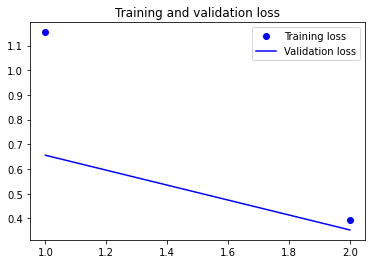

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 11. RNN 응용
- 입력에서의 시간 순서가 반영 안된 앞의 예
- sequence 데이터로 반영: 시간 순서를 적용
- GRU의 활용(RNN의 한 종류, LSTM의 단순화 버전)

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 22s 29ms/step - loss: 0.3504 - val_loss: 0.2765
Epoch 2/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2874 - val_loss: 0.2648
Epoch 3/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2799 - val_loss: 0.2660
Epoch 4/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2732 - val_loss: 0.2647
Epoch 5/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2709 - val_loss: 0.2631
Epoch 6/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2673 - val_loss: 0.2652
Epoch 7/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2637 - val_loss: 0.2678
Epoch 8/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2596 - val_loss: 0.2698
Epoch 9/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2573 - val_loss: 0.2701
Epoch 10/20
500/500 [==============================] - 14s 29ms/step - loss: 0.256

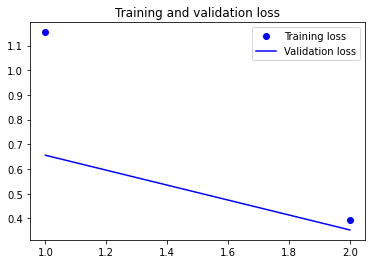

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- dropout의 적용
 - 순환층에 적용 가능한 dropout 파라미터
  - dropout: 층의 입력에 대한 드롭아웃 비율
  - recurrent_dropout: 순환 상태의 드롭아웃 비율
 
  -training vs validation: 몇번째 epoch에서 역전(=overfitting)? 


In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


500/500 [==============================] - 401s 797ms/step - loss: 0.3216 - val_loss: 0.2780


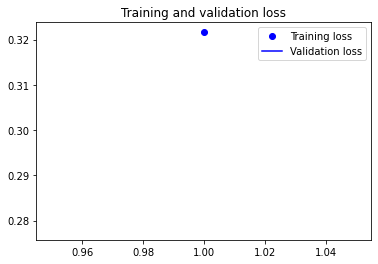

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 12. Stacking Recurrent Layers
- 학습 시 병목 현상
- 네트워크 용량 증가를 위한 노드 또는 층 추가
- stacking recurrent layers
- 모든 중간 층은 마지막 time step 출력만이 아닌, 전체 sequence(3d tensor) 출력
- return_sequences=True로 지정

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


500/500 [==============================] - 836s 2s/step - loss: 0.3195 - val_loss: 0.2854


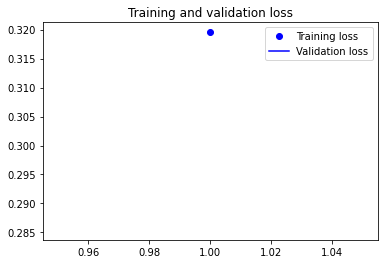

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


## 13. 양방향 RNN
- 기본 RNN 대비 우수
- 순서가 중요한 RNN, 순서(time step)을 섞거나 반전->Sequence에 대한 학습 표현이 영향
- 양방향 RNN: 앞서 보았던 GRU나 LSTM 같은 RNN 두 개를 사용
- 각 RNN은 입력 시퀀스를 한 방향(시간의 순서나 반대 순서)으로 처리한 다음 각 표현을 합치게 됨
- 시퀀스를 양쪽 방향으로 처리하기 때문에 양방향 RNN은 단방향 RNN이 놓치기 쉬운 패턴을 감지
- 시간 순서와 그 반대방향을 갖는 sequence 생성
- input data generator: 함수의 마지막 줄을 yield samples[:, ::-1, :], targets:

In [ ]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


500/500 [==============================] - 18s 32ms/step - loss: 0.4783 - val_loss: 0.4796


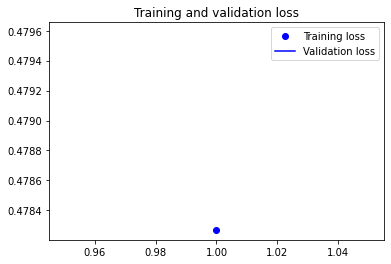

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- 성능이 좋지는 않음: GRU는 최근 관측치를 더 잘 활용, 과거-현재의 시간순서가 유리
- 자연어의 경우에는 그렇지 않을 수 있음
- imdb 예제를 아래처럼 양방향 적용

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# 특성으로 사용할 단어의 수
max_features = 10000
# 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
maxlen = 500

# 데이터 로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 시퀀스를 뒤집습니다
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# 시퀀스에 패딩을 추가합니다
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

157/157 [==============================] - 6s 27ms/step - loss: 0.5027 - acc: 0.7527 - val_loss: 0.3788 - val_acc: 0.8522


 - LSTM과 유사한 성능: 텍스트는 양방향도 잘 작동함
 - 입력 sequence를 양 방향에서 접근하여, 나타나지 않았던 입력에 대한 표현을 발견할 수 있기 때문

- Bidirectional RNN 구성요소
 - 첫 번째 매개변수로 순환 층의 객체
 - Bidirectional 클래스는 전달받은 순환 층으로 새로운 두 번째 객체
 - 하나는 시간 순서대로 입력 시퀀스를 처리하고 다른 하나는 반대 순서로 입력 시퀀스를 처리
 - IMDB에 적용

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 10s 42ms/step - loss: 0.5594 - acc: 0.7126 - val_loss: 0.4226 - val_acc: 0.8216
Epoch 2/10
157/157 [==============================] - 6s 37ms/step - loss: 0.3388 - acc: 0.8687 - val_loss: 0.3670 - val_acc: 0.8462
Epoch 3/10
157/157 [==============================] - 6s 37ms/step - loss: 0.2669 - acc: 0.9035 - val_loss: 0.3167 - val_acc: 0.8758
Epoch 4/10
157/157 [==============================] - 6s 37ms/step - loss: 0.2375 - acc: 0.9119 - val_loss: 0.3436 - val_acc: 0.8496
Epoch 5/10
157/157 [==============================] - 6s 37ms/step - loss: 0.2028 - acc: 0.9287 - val_loss: 0.3284 - val_acc: 0.8802
Epoch 6/10
157/157 [==============================] - 6s 37ms/step - loss: 0.1814 - acc: 0.9371 - val_loss: 0.3407 - val_acc: 0.8818
Epoch 7/10
157/157 [==============================] - 6s 37ms/step - loss: 0.1674 - acc: 0.9421 - val_loss: 0.3530 - val_acc: 0.8738
Epoch 8/10
157/157 [==============================] - 6s 37ms/step -

 - 성능 개선
 - 오버피팅
 - 기온 예제에도 적용

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


500/500 [==============================] - 45s 40ms/step - loss: 0.2950 - val_loss: 0.2711


 - 성능 개선을 위한
  - 은닉층 구조 조정
  - 학습율 조정
  - GRU대신 LSTM
  